#SUBWAY DATA

In [1]:
import csv
import datetime
import os
import pandas as pd
import numpy as np

from sets import Set
from dateutil.parser import parse
import matplotlib.pyplot as plt

import requests
import urllib2

from bs4 import BeautifulSoup as bs
from dateutil.parser import parse

%matplotlib inline
pd.options.display.mpl_style = 'default'

## Single File - Old Data

### Quick Overview

Firstly, I'm going to load in one file from an earlier that I've manually downloaded from the MTA website at http://web.mta.info/developers/turnstile.html. After I get a sense of one subset of the data and how to clean it, I'll make a script to download all of the data files, clean and combine them.

In [5]:
filename = "data/turnstile/turnstile_110528.txt"
df_turnstile = pd.read_csv(filename)
df_turnstile.head(2)

,A002,R051,02-00-00,05-21-11,00:00:00,REGULAR,003169391,001097585,05-21-11.1,04:00:00,...,05-22-11,00:00:00.1,REGULAR.6,003170119,001097792,05-22-11.1,04:00:00.1,REGULAR.7,003170146,001097801
0,A002,R051,02-00-00,05-22-11,08:00:00,REGULAR,3170164,1097820,05-22-11,12:00:00,...,05-23-11,08:00:00,REGULAR,3170746,1098069,05-23-11,12:00:00,REGULAR,3170897,1098378
1,A002,R051,02-00-00,05-23-11,16:00:00,REGULAR,3171194,1098447,05-23-11,20:00:00,...,05-24-11,16:00:00,REGULAR,3172689,1099010,05-24-11,20:00:00,REGULAR,3173590,1099055


In [6]:
filename = "data/turnstile/turnstile_110528.txt"
df_turnstile = pd.read_csv(filename)
df_turnstile.head(2)

,A002,R051,02-00-00,05-21-11,00:00:00,REGULAR,003169391,001097585,05-21-11.1,04:00:00,...,05-22-11,00:00:00.1,REGULAR.6,003170119,001097792,05-22-11.1,04:00:00.1,REGULAR.7,003170146,001097801
0,A002,R051,02-00-00,05-22-11,08:00:00,REGULAR,3170164,1097820,05-22-11,12:00:00,...,05-23-11,08:00:00,REGULAR,3170746,1098069,05-23-11,12:00:00,REGULAR,3170897,1098378
1,A002,R051,02-00-00,05-23-11,16:00:00,REGULAR,3171194,1098447,05-23-11,20:00:00,...,05-24-11,16:00:00,REGULAR,3172689,1099010,05-24-11,20:00:00,REGULAR,3173590,1099055


In [7]:
df_turnstile.shape

(998, 43)

There are 998 rows and an overwhelming 43 columns in this dataset. This file was written in a way where multiple observations share the same row. As a result the MTA data is notoriously difficult to work with. As adaptable as the pandas module is, it can't infer this kind of error and correct it. So I'll have to manually do it myself.

Looking at the time and date columns, it's clear that each file spans exactly one week at 4 hour intervals. The time diference between each consecutive row is 32 hours.

The MTA website labels the data as follows: 'C/A, UNIT, SCP, DATEn, TIMEn, DESCn, ENTRIESn, EXITSn'. The first 3 columns are identification data. Then elements should be chopped from the original data, 5 elements at a time and written into the new file. Next is a sequence of columns with a timestamp, type of report, entry count, and exit count, which repeats 8 times! This figure lines up with the shape of our dataframe (3 + (5 x 8)) = 43.



### Restructuring the data

In [10]:
def fix_turnstile_data(filepath):
    '''
    Filepath is a location of a MTA Subway turnstile text file.A link to an example
    MTA Subway turnstile text file can be seen at the URL below:
    http://web.mta.info/developers/data/nyct/turnstile/turnstile_110507.txt
    
    There are numerous data points included in each row of the text file. 

    This function updates each row in the text file so there is only one entry per row.
    A few examples below:
    A002,R051,02-00-00,05-28-11,00:00:00,REGULAR,003178521,001100739
    A002,R051,02-00-00,05-28-11,04:00:00,REGULAR,003178541,001100746
    A002,R051,02-00-00,05-28-11,08:00:00,REGULAR,003178559,001100775
    
    This file is then written into a new related directory.
    '''
    
    for file in filepath:
        
        # Parse the directory and filename from the input.
        splitted = file.split('/')
        directory, filename = splitted[0:2], splitted[2]

        # Read the file into memory.
        r = csv.reader(open(file, 'rb'))

        # Prepare the output directory.
        newpath = "data/turnstile/updated_data"
        #newpath = 'data/turnstile'
        
        if not os.path.exists(newpath): 
            os.makedirs(newpath)

        # Create the output file in the new directory. Overwrite the file if it exists already(wb).
        w = csv.writer(open("{0}/{1}".format(newpath, filename), 'wb'))

        # Write the header row, taken from the mta website.
        w.writerow(['C/A', 'UNIT', 'SCP', 'DATEn', 'TIMEn', 'DESCn', 'ENTRIESn', 'EXITSn'])

        # Loop through the output from the CSV reader a line at a time.
        for line in r:

            # Parse out the elements, and remove them from the row.
            ca = line.pop(0)
            unit = line.pop(0)
            scp = line.pop(0)

            # While there is still new data, parse it.
            while len(line) >= 5:

                # Take the first 5 elements and remove them.
                block, line = line[:5], line[5:]

                # Output the new row.
                w.writerow([ca, unit, scp] + block)

As it turns out, the MTA have been overhauling their data collection. Their website, API and even the data recording method have changed. The new files are all structured nicely, meaning that the previous work was unneccessary. Oh well, it was good data munging practice at least so I'll leave it in for future reference!

## Single File - Old Data

In [44]:
# Load in a new, recent record.
newfile = 'data/turnstile/150502.txt'
df = pd.read_csv(newfile)
df.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649


In [45]:
df.shape

(192388, 11)

As I mentioned before this is a much nicer format to work with. There is one tiny thing that needs to be corrected straight away though.

In [46]:
df.columns.values

array(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE',
       'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '], dtype=object)

There's trailing white space after EXITS. I tried experimenting with different partameteres for read_csv but nothing was working, so I need to manually deal with it.

In [47]:
df.columns = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']

## Understanding the Variables

From the documentation on [MTA](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt), here's what the variables mean:


````
======================================
Field Description

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS

C/A      = Control Area (A002) - Booth
UNIT     = Remote Unit for a station (R051)
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
STATION  = Represents the station name the device is located at
LINENAME = Represents all train lines that can be boarded at this station
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
DATE     = Represents the date (MM-DD-YY)
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
ENTRIES  = The comulative entry register value for a device
EXIST    = The cumulative exit register value for a device


Example:
The data below shows the entry/exit register values for one turnstile at control area (A002) from 09/27/14 at 00:00 hours to 09/29/14 at 00:00 hours

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,00:00:00,REGULAR,0004800073,0001629137,
A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,04:00:00,REGULAR,0004800125,0001629149,
A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,08:00:00,REGULAR,0004800146,0001629162,
A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,12:00:00,REGULAR,0004800264,0001629264,
======================================
````

In order to get a unique turnstile you need to provide the C/A UNIT and SCP reference. Here is a good way to help understand the identifier columns:

In [48]:
df.groupby(['C/A', 'UNIT', 'SCP']).first().head(20)

STATION LINENAME DIVISION        DATE      TIME  \
C/A  UNIT SCP                                                               
A002 R051 02-00-00  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-00-01  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-03-00  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-03-01  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-03-02  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-03-03  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-03-04  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-03-05  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-03-06  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-05-00  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-05-01  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
          02-06-00  LEXINGTON AVE   NQR456      BMT  04/25/2015  00:00:00   
A006 R079 00-00-00    5 AVE-59 ST      NQR      BMT  04/25/2015  02:00:00   
          00-00-01    5 AVE-59 ST      NQR      BMT  04/25/2015  02:00:00   
          00-00-02    5 AVE-59 ST      NQR      BMT  04/25/2015  02:00:00   
          00-00-03    5 AVE-59 ST      NQR      BMT  04/25/2015  02:00:00   
          00-00-04    5 AVE-59 ST      NQR      BMT  04/25/2015  02:00:00   
          00-03-00    5 AVE-59 ST      NQR      BMT  04/25/2015  02:00:00   
          00-03-01    5 AVE-59 ST      NQR      BMT  04/25/2015  02:00:00   
          00-03-02    5 AVE-59 ST      NQR      BMT  04/25/2015  02:00:00   

                       DESC   ENTRIES     EXITS  
C/A  UNIT SCP                                    
A002 R051 02-00-00  REGULAR   5106770   1729635  
          02-00-01  REGULAR   4731487   1032592  
          02-03-00  REGULAR    485048   1830747  
          02-03-01  REGULAR   4676295   7354831  
          02-03-02  REGULAR   4408528   6068297  
          02-03-03  REGULAR   4047887   4939492  
          02-03-04  REGULAR   5135141   2900798  
          02-03-05  REGULAR   8355786   1197453  
          02-03-06  REGULAR   6513528    461989  
          02-05-00  REGULAR      1152         0  
          02-05-01  REGULAR         0       593  
          02-06-00  REGULAR   5657918    132787  
A006 R079 00-00-00  REGULAR   1602728   2894883  
          00-00-01  REGULAR   2883227   1939818  
          00-00-02  REGULAR   6874354   3076458  
          00-00-03  REGULAR   1613980    620019  
          00-00-04  REGULAR   6353539   2835580  
          00-03-00  REGULAR   7374652   3366349  
          00-03-01  REGULAR   1115145    585472  
          00-03-02  REGULAR  12626359  13402937

##Preparing the Data

### Observations not on the Hour

The data for the turnstile is written on the hour and in 4 hour intervals. Sometimes the first entry is midnight, sometimes 1am etc. Any entry that is not on the hour is most likely due to maintenance and can be ignored.

In [49]:
filter_onhour = [((pd.to_datetime(df.TIME[n])).minute != 0) for n in range(len(df))]

In [50]:
df[filter_onhour].head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1707,A013,R081,01-00-00,49 ST-7 AVE,NQR,BMT,04/29/2015,08:12:40,REGULAR,5270306,30939048
1750,A013,R081,01-03-00,49 ST-7 AVE,NQR,BMT,04/29/2015,08:12:40,REGULAR,2911534,3345354


In [51]:
df.ix[[1706, 1707, 1708]]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1706,A013,R081,01-00-00,49 ST-7 AVE,NQR,BMT,04/29/2015,08:00:00,REGULAR,5270301,30938948
1707,A013,R081,01-00-00,49 ST-7 AVE,NQR,BMT,04/29/2015,08:12:40,REGULAR,5270306,30939048
1708,A013,R081,01-00-00,49 ST-7 AVE,NQR,BMT,04/29/2015,12:00:00,REGULAR,5270372,30940882


The extra row from maintenance doesn't capture any information that the other 2 don't already. Therefore I'm going to remove all non-hour rows.

In [52]:
df2 = df.drop(list(df.loc[filter_onhour].index))
df2 = df2.reset_index()
df = df2

### Different Types

There are different types of "DESC" according to the documentation.

===========================
````
Descn Possible Values (Events):
REGULAR - Regular scheduled audit event
NO-VAL LGN - Not Valid logon
LGF-MAN - Logoff Manual
LGF-DR CLS - Logoff Door Closed
LGF-SHUTDN - Logoff Shutdown
TS BRD CHG - Turnstile Board Change
TS VLT OPN - Turnstile Vault Open
RECOVR AUD - Recovery audit - if REGULAR was not delivered due to communications problems
````
===========================


In [53]:
df.DESC.unique()

array(['REGULAR', 'RECOVR AUD'], dtype=object)

In [54]:
df[df.DESC == 'RECOVR AUD'].head(5)

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1113,1113,A010,R080,00-00-00,57 ST-7 AVE,NQR,BMT,04/28/2015,12:00:00,RECOVR AUD,143112,85613
1155,1155,A010,R080,00-00-01,57 ST-7 AVE,NQR,BMT,04/28/2015,12:00:00,RECOVR AUD,12250490,4537590
1197,1197,A010,R080,00-00-02,57 ST-7 AVE,NQR,BMT,04/28/2015,12:00:00,RECOVR AUD,8936510,3456835
1239,1239,A010,R080,00-00-03,57 ST-7 AVE,NQR,BMT,04/28/2015,12:00:00,RECOVR AUD,1865400,918583
1281,1281,A010,R080,00-00-04,57 ST-7 AVE,NQR,BMT,04/28/2015,12:00:00,RECOVR AUD,2550498,1228635


In [55]:
df.iloc[[1110, 1112, 1113, 1114, 1115]]

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1110,1110,A010,R080,00-00-00,57 ST-7 AVE,NQR,BMT,04/28/2015,00:00:00,REGULAR,142599,84827
1112,1112,A010,R080,00-00-00,57 ST-7 AVE,NQR,BMT,04/28/2015,08:00:00,REGULAR,142744,85024
1113,1113,A010,R080,00-00-00,57 ST-7 AVE,NQR,BMT,04/28/2015,12:00:00,RECOVR AUD,143112,85613
1114,1114,A010,R080,00-00-00,57 ST-7 AVE,NQR,BMT,04/28/2015,16:00:00,REGULAR,143638,85933
1115,1115,A010,R080,00-00-00,57 ST-7 AVE,NQR,BMT,04/28/2015,20:00:00,REGULAR,144687,86304


In this dataset there are only two different types, REGULAR and RECOVR AUD. Fortunately RECOVR AUD does not require any further thought as it gives the same reading as REGULAR, but as a backup communication.

###Dates and Times

It's very useful to have a datetime object within the DF in order to make calculations. I'll make a new columns named "DATE-TIME".

In [56]:
# Convert to datetime.
df['DATE-TIME'] = pd.to_datetime(df['DATE'] + " " + df['TIME'])

# Drop old TIME and DATE columns.
df = df.drop(['DATE', 'TIME'], axis=1)
df.head(2)

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATE-TIME
0,0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,5106770,1729635,2015-04-25 00:00:00
1,1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,5106810,1729649,2015-04-25 04:00:00


###Entries and Exits

The original data set gives running totals for each turnstile instead of just a number of entries or exits, so to get anything useful out of it, I'll need to do some subtraction. This function took a lot of effort to make it work with the often inconsistent logging data. It is also not vectorized, meaning that the pandas library cannot speed up the process and took hours to complete for the final dataset. Nevertheless it worked and is fairly simple to understand.


\begin{align*}
hourlyentries(t) = entries(t)  −entries(t−1)
\end{align*}

In [142]:
df1 = df.drop(df.index[100:])

In [143]:
df1.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATE-TIME,HOURLY_ENTRIES
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,5106770,1729635,2015-04-25 00:00:00,0
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,5106810,1729649,2015-04-25 04:00:00,NaN


In [486]:
def cumulative_to_hourly(df):
    """
    Takes a DF as input and calculates the hourly entries and exits for each turnstile.
    If the turnstile has no previous entries in the DF, then it is initialized to zero.
    Otherwise the previous cumulative value is looked up and subtracted from current one
    to get the new hourly.  
    
    Good overview on view vs copy here: 
    http://stackoverflow.com/questions/27367442/pandas-dataframe-view-vs-copy-how-do-i-tell

    """
    
    for i, entry in df.iterrows():

        # Check the DF for entries for this specific turnstile.
        previous_entries = df[(df['C/A']==entry['C/A']) & (df['UNIT']==entry['UNIT']) & 
                              (df['SCP']==entry['SCP']) & (df.index < i)]

        # If this is the first entry then initialize to zero.
        if len(previous_entries) == 0:   
         
            df.loc[i, 'HOURLY_ENTRIES'] = 0
            df.loc[i, 'HOURLY_EXITS'] = 0

        # Otherwise, look up previous entry for that turnstile.
        else:
            
            # Get the index of the previous one entry.
            j = max(previous_entries.index)

            # Subtract the current cumulative value from the previous one.
            df.loc[i, 'HOURLY_ENTRIES'] = df.loc[i, 'ENTRIES'] - df.loc[j, 'ENTRIES']
            df.loc[i, 'HOURLY_EXITS'] = df.loc[i, 'EXITS'] - df.loc[j, 'EXITS']

This is all the work it requires to prepare one file for analysis. Now it's time to scrape all the neccessary files from the internet and merge them into one dataset.

## Scraping Files

I'm choosing the last complete month to do analysis on which is May 2015. The MTA collect data weekly, so I'm also going to take the last week of April, and the first month of June.

The files are available for download here: http://web.mta.info/developers/turnstile.html

I'll be using the python module Beautiful Soup to parse the html in order to find the relevant hyperlinks quickly.

There was an odd error with beautiful soup - some byte code on the page couldn't be converted to ASCII characters. After a quick google, I found the following fix on stackoverflow.

In [ ]:
# Work around for byte-ASCII error in bs.
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

In [ ]:
# URL of MTA data.
URL = 'http://web.mta.info/developers/turnstile.html'

# Parse the html using bs to find the hyperlinks.
r = requests.get(URL)
soup = bs(r.text)
hyperlinks = soup.findAll('a')

# Initialize array to hold all of the URLs on the page.
urls = []

# Loop through the hyperlinks, parsing just the links themselves.
for each in hyperlinks:
    link = each.get('href')
    
    # Only add links which are in the data directory, and are text files.
    if link and link.endswith('.txt') and link.startswith('data/'):
        urls.append(link)

In [ ]:
# Initialize array to hold all of the dates from the URLs collected.
dates = []

# Split the URLs up in order to get just the dates.
for each in urls:
    filename = each.split('/')[-1]
    filename.find('turnstile_')
    index = filename.find('turnstile_')
    date = filename[index+len('turnstile_'):].split('.')[0]
    dates.append(date)

In [ ]:
# Initialize set to store the dates to download.
dates_to_download = Set([])

# Loop through the dates, and take the appropriate ones.
for i, date in enumerate(dates):
    # Only 2015.
    if date[:2] == '15':
        # Take all of May, the last week of April, and the first week of June.
        if date[2:4] == '05':
            dates_to_download.update([dates[i-1], dates[i], dates[i+1]])

# Convert the set to an array.            
dates_to_download = list(dates_to_download)

In [ ]:
dates_to_download = sorted(dates_to_download)
#dates_to_download = ['150425', '150502', '150509', '150516', '150523', '150530', '150606']

In [ ]:
l = len(dates_to_download)

# Loop through the dates, downloading the corresponding file.
for i in range(l):
    date = dates_to_download[i]
    download = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{0}.txt'.format(date)

## Combining Files

Once all the neccessary subway data has been downloaded, it's time to combine it in some fashion. One possbility is to load all the files into invididual dataframes using pandas, and then merging them and writing. Instead I decided to open the files one by one and write the contents into a new file, as this requires less memory usage.

In [2]:
def combine_turnstile_data(filenames):
    """
    Takes the turnstile filenames and writes them one by one into a new
    file.
    """
    
    # Open a new master file, and write in the header row.
    with open('updated_data/master_file.txt', 'w') as master_file:
        master_file.write('C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESCn,ENTRIES,EXITS\n')
    
        # Open all the files and write thme into master file.
        for filename in filenames:
            with open('data/turnstile/{0}.txt'.format(filename),'rb') as f:
                for row in f:
                    # Ignore the the header row.
                    if row.startswith('C/A'):
                        continue
                    master_file.write(row)

In [ ]:
combine_turnstile_data(dates_to_download)

In [3]:
df_turnstile_master = pd.read_csv('updated_data/master_file.txt')

In [4]:
df_turnstile_master.head(1)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESCn,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/18/2015,00:00:00,REGULAR,5095940,1725998


## Multiple Files

Now that the files are joined together I'll prepare them similarly to before.

In [5]:
filter_onhour = [((pd.to_datetime(df_turnstile_master.TIME[n])).minute != 0) for n in range(len(df_turnstile_master))]

In [6]:
# Apply filter to remove non-hour entries.
df_turnstile_master = df_turnstile_master.drop(list(df_turnstile_master.loc[filter_onhour].index))
df_turnstile_master = df_turnstile_master.reset_index()

In [7]:
# Convert to datetime.
df_turnstile_master['DATE-TIME'] = pd.to_datetime(df_turnstile_master['DATE'] + " " + df_turnstile_master['TIME'])

# Drop old TIME and DATE columns.
#df_turnstile_master = df_turnstile_master.drop(['DATE', 'TIME'], axis=1)

In addition to the previous cleaning I must also remove the non-May dates from the dataframe.

In [8]:
# Checking if the dates are in order.
pd.Series(df_turnstile_master['DATE-TIME'].ravel()).unique()

array(['2015-04-18T01:00:00.000000000+0100',
       '2015-04-18T05:00:00.000000000+0100',
       '2015-04-18T09:00:00.000000000+0100', ...,
       '2015-06-05T10:00:53.000000000+0100',
       '2015-06-03T06:00:01.000000000+0100',
       '2015-06-05T10:00:58.000000000+0100'], dtype='datetime64[ns]')

In [9]:
before = df_turnstile_master.shape[0]

# Convert the date_n col to a datetime and extract the month.
month_filter =  pd.DatetimeIndex(df_turnstile_master['DATE-TIME']).month

# Convert to a Series in order to do filter operation on the df.
month_filter = pd.Series(month_filter)

# Subset the df, based on the month being May.
df_turnstile_master = df_turnstile_master[month_filter == 5]

after = df_turnstile_master.shape[0]

In [10]:
df_turnstile_master = df_turnstile_master.reset_index()

In [11]:
df_turnstile_master = df_turnstile_master.drop(['level_0', 'index'], axis=1)

In [12]:
df_turnstile_master.head(1)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESCn,ENTRIES,EXITS,DATE-TIME
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,00:00:00,REGULAR,5115461,1732389,2015-05-01


In [240]:
df_turnstile_master.to_csv('updated_data/master_file_onhour.txt', index=False)

In [241]:
df_turnstile_master = pd.read_csv('updated_data/master_file_onhour.txt')

Since my cumulative_to_hourly function takes so long to complete I used a loop to do it incremently to avoid crashes and check on its progress.

In [234]:
df_turnstile_master[pd.isnull(df_turnstile_master).any(1)]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESCn,ENTRIES,EXITS,DATE-TIME,HOURLY_ENTRIES,HOURLY_EXITS
16,A002,R051,02-03-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,16:00:00,REGULAR,488802,1843726,2015-05-01 16:00:00,147,NaN
277835,N316,R267,00-00-00,46 ST,MR,IND,05/15/2015,21:00:00,REGULAR,3796272,3068712,2015-05-15 21:00:00,NaN,NaN
277836,N316,R267,00-00-01,46 ST,MR,IND,05/09/2015,01:00:00,REGULAR,3141441,805431,2015-05-09 01:00:00,NaN,NaN
277837,N316,R267,00-00-01,46 ST,MR,IND,05/09/2015,05:00:00,REGULAR,3141458,805454,2015-05-09 05:00:00,NaN,NaN
277838,N316,R267,00-00-01,46 ST,MR,IND,05/09/2015,09:00:00,REGULAR,3141579,805497,2015-05-09 09:00:00,NaN,NaN
277839,N316,R267,00-00-01,46 ST,MR,IND,05/09/2015,13:00:00,REGULAR,3141826,805579,2015-05-09 13:00:00,NaN,NaN
277840,N316,R267,00-00-01,46 ST,MR,IND,05/09/2015,17:00:00,REGULAR,3142019,805723,2015-05-09 17:00:00,NaN,NaN
277841,N316,R267,00-00-01,46 ST,MR,IND,05/09/2015,21:00:00,REGULAR,3142177,805893,2015-05-09 21:00:00,NaN,NaN
277842,N316,R267,00-00-01,46 ST,MR,IND,05/10/2015,01:00:00,REGULAR,3142238,805986,2015-05-10 01:00:00,NaN,NaN
277843,N316,R267,00-00-01,46 ST,MR,IND,05/10/2015,05:00:00,REGULAR,3142245,806002,2015-05-10 05:00:00,NaN,NaN


In [451]:
l = len(df_turnstile_master)
base, step = 0, 1000
for i in range(base, l, step):
    print "{}\t {} \t STARTED AT {}".format(base, i, datetime.datetime.now().time())
    cumulative_to_hourly(df_turnstile_master[base:i])
    print "DONE AT {}".format(datetime.datetime.now().time())
    base += step

276845	 277845 	 STARTED AT 21:06:53.735000
DONE AT 21:06:53.897000
277845	 278845 	 STARTED AT 21:06:53.897000
DONE AT 21:08:24.697000
278845	 279845 	 STARTED AT 21:08:24.697000
DONE AT 21:09:57.634000
279845	 280845 	 STARTED AT 21:09:57.635000
DONE AT 21:11:29.417000
280845	 281845 	 STARTED AT 21:11:29.418000
DONE AT 21:13:00.672000
281845	 282845 	 STARTED AT 21:13:00.672000
DONE AT 21:14:33.009000
282845	 283845 	 STARTED AT 21:14:33.009000
DONE AT 21:16:04.550000
283845	 284845 	 STARTED AT 21:16:04.551000
DONE AT 21:17:35.824000
284845	 285845 	 STARTED AT 21:17:35.825000
DONE AT 21:19:06.161000
285845	 286845 	 STARTED AT 21:19:06.161000
DONE AT 21:20:37.193000
286845	 287845 	 STARTED AT 21:20:37.193000
DONE AT 21:22:08.219000
287845	 288845 	 STARTED AT 21:22:08.220000
DONE AT 21:23:37.752000
288845	 289845 	 STARTED AT 21:23:37.752000
DONE AT 21:25:09.419000
289845	 290845 	 STARTED AT 21:25:09.420000
DONE AT 21:26:40.934000
290845	 291845 	 STARTED AT 21:26:40.935000
DONE

In [462]:
df_turnstile_master.to_csv('data/final/backup_turnstile_final.csv', index=False)

###Bad Values

There are some hourly entries that have bad values. After some investigation I found an answer and guideline on what to do with these at https://groups.google.com/forum/#!topic/mtadeveloperresources/hKQ_k9DwyEU.

"My colleague Ivan Khilko and I have been working with that dataset and have gotten some info from MTA. The count does indeed drop sometimes. This happens most frequently when there is maintenance on a turnstile, and you can see the numbers jump around in a few different lines when there is maintenance. Our basic steps to dealing with this are to first remove the transactions that don't occur exactly on an hour, difference only transactions that are four hours apart (to avoid including odd entries, such as a door being opened for maintenance, that happen to fall on an exact hours, and then delete any observations that have a first difference that is negative or too large to be an accurate reading."

In [527]:
df_turnstile_master.shape

(776265, 15)

In [16]:
# Subset only the positive values.
df_turnstile_master = df_turnstile_master[df_turnstile_master['HOURLY_ENTRIES'] >= 0]
df_turnstile_master = df_turnstile_master[df_turnstile_master['HOURLY_EXITS'] >= 0]

Negative values are easy, but what consitutes a value that is too large? After playing with the cutoff threshold for the number of hourly entries I found that anything above 10000 can be safely considered as bad data.

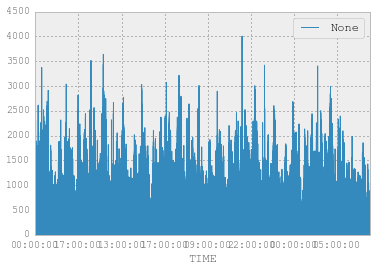

In [529]:
df_turnstile_master = df_turnstile_master[df_turnstile_master['HOURLY_ENTRIES'] < 10000]
df_turnstile_master.plot(y='HOURLY_ENTRIES', x='TIME')

In [530]:
df_turnstile_master.shape

(776265, 15)

###Adding Weekday

In order to find trends within the data it will be useful to know which day a certain day is on.

In [473]:
type(df_turnstile_master['DATE-TIME'][0])

str

In [19]:
df_turnstile_master['WEEKDAY'] = df_turnstile_master['DATE-TIME'].apply(lambda x: pd.to_datetime(x).strftime('%A'))
df_turnstile_master['DAY_OF_WEEK'] = df_turnstile_master['DATE-TIME'].apply(lambda x: pd.to_datetime(x).weekday())

In [20]:
df_turnstile_master.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESCn,ENTRIES,EXITS,DATE-TIME,HOURLY_ENTRIES,HOURLY_EXITS,WEEKDAY,DAY_OF_WEEK
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,00:00:00,REGULAR,5115461,1732389,2015-05-01 00:00:00,0,0,Friday,4
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,04:00:00,REGULAR,5115480,1732394,2015-05-01 04:00:00,19,5,Friday,4
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,08:00:00,REGULAR,5115524,1732482,2015-05-01 08:00:00,44,88,Friday,4
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,12:00:00,REGULAR,5115678,1732624,2015-05-01 12:00:00,154,142,Friday,4
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,16:00:00,REGULAR,5115998,1732647,2015-05-01 16:00:00,320,23,Friday,4


###Fixing Date

In [541]:
df_turnstile_master['DATE']

0     05/01/2015
1     05/01/2015
2     05/01/2015
3     05/01/2015
4     05/01/2015
5     05/01/2015
6     05/01/2015
7     05/01/2015
8     05/01/2015
9     05/01/2015
10    05/01/2015
11    05/01/2015
12    05/01/2015
13    05/01/2015
14    05/01/2015
...
776250    05/31/2015
776251    05/31/2015
776252    05/31/2015
776253    05/30/2015
776254    05/30/2015
776255    05/30/2015
776256    05/30/2015
776257    05/30/2015
776258    05/30/2015
776259    05/31/2015
776260    05/31/2015
776261    05/31/2015
776262    05/31/2015
776263    05/31/2015
776264    05/31/2015
Name: DATE, Length: 776265, dtype: object

In [ ]:
datetime.datetime.strptime("2013-1-25", '%Y-%m-%d').strftime('%m/%d/%y')

In [ ]:
df_turnstile_master['DATE'] = ([df_turnstile_master(df["DATE"]).strftime('%Y-%m-%d') for n in range(len(df))])

##Exporting Final File

In [21]:
df_turnstile_master.to_csv('data/final/turnstile_final.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

In [2]:
df_turnstile_master = pd.read_csv('data/final/turnstile_final.csv')

In [3]:
df_turnstile_master.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESCn,ENTRIES,EXITS,DATE-TIME,HOURLY_ENTRIES,HOURLY_EXITS,WEEKDAY
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,00:00:00,REGULAR,5115461,1732389,2015-05-01 00:00:00,0,0,Friday
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,04:00:00,REGULAR,5115480,1732394,2015-05-01 04:00:00,19,5,Friday
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,08:00:00,REGULAR,5115524,1732482,2015-05-01 08:00:00,44,88,Friday
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,12:00:00,REGULAR,5115678,1732624,2015-05-01 12:00:00,154,142,Friday
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,05/01/2015,16:00:00,REGULAR,5115998,1732647,2015-05-01 16:00:00,320,23,Friday
